In [1]:
# some early test of lqg on linear RNN
import numpy as np
import sys
from rnn_lin import RNN
import matplotlib.pyplot as plt
import json
import torch
import control

## Loading Trained Weights

In [2]:
with open('SIN_lin_32_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [3]:
weight_history.keys()

dict_keys(['trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses', 'weight_posneg'])

In [4]:
# gains = np.array(weight_history['trained gain'])
# shifts = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weights = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])
weight_posneg = np.array(weight_history['weight_posneg'])
weight_matrix = np.abs(weight_matrix) * weight_posneg

## Defining Network

In [5]:
time_constant = 100 #ms
timestep = 10 #ms
time = 3000 #ms
num_inputs = 1
num_nodes = 32
init_activations = np.zeros((num_nodes, 1))

network = RNN(weight_matrix, connectivity_matrix, init_activations, None, None, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep)

In [6]:
# define inputs and targets
nt = 300
time_points = np.arange(nt).reshape(-1, 1)
inputs = np.sin(time_points/60*np.pi)
targets = np.sin((time_points+1)/60*np.pi)
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)

# define matrices
A = weight_matrix - np.diag(np.ones(num_nodes))
B = np.diag(np.ones(num_nodes))
C = np.diag(np.ones(num_nodes))
G = np.diag(np.ones(num_nodes))
Q = np.diag(np.ones(num_nodes)) * 1
R = np.diag(np.ones(num_nodes)) * 0.01
Qn = np.diag(np.ones(num_nodes)) * 0.1
Rn = np.diag(np.ones(num_nodes)) * 0.1
c = network.timestep/network.time_const

# define noise
x_noises = (np.random.multivariate_normal(mean=np.zeros(num_nodes), cov=Qn, size=nt)).T
y_noises = (np.random.multivariate_normal(mean=np.zeros(num_nodes), cov=Rn, size=nt)).T

x_noises[:,100:150] += 1
x_noises

array([[ 0.47142654, -0.52070154, -0.36856638, ..., -0.10680564,
        -0.34226013,  0.37463299],
       [ 0.11109188,  0.35529453,  0.4086984 , ...,  0.26405033,
        -0.25718636,  0.08157759],
       [ 0.3163662 , -0.61793477, -0.19518219, ..., -0.08379201,
         0.24971785,  0.15789833],
       ...,
       [ 0.03584693, -0.28363149,  0.16879812, ...,  0.29008406,
        -0.48554191, -0.25977321],
       [ 0.51260959,  0.53902864, -0.22168954, ...,  0.40881127,
        -0.44387451,  0.07648124],
       [-0.03445151,  0.01938288,  0.20116256, ..., -0.04216992,
        -0.15307539,  0.46204215]])

In [7]:
# from model
outputs, activations = network.simulate(time, torch.tensor(inputs).float(), input_weights) 

100%|██████████| 300/300 [00:00<00:00, 32264.70it/s]


In [8]:
# manual simulation without feedback, with noise
c = network.timestep/network.time_const
activations_nofb = [init_activations]
outputs_nofb = []
for t in time_points:
    last_acitvation = activations_nofb[-1]
    this_input = inputs[t] * input_weights.T
    this_noise = x_noises[:,t]
    # this_noise = 0
    this_activation = (1 - c) * last_acitvation + c * weight_matrix @ last_acitvation + c * this_input + c * this_noise
    this_output = output_weight_matrix @ this_activation
    activations_nofb.append(this_activation)
    outputs_nofb.append(this_output.item())

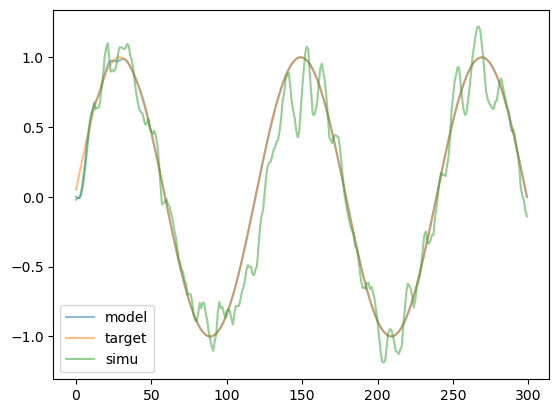

In [9]:
# check manual simulation
fig, ax = plt.subplots()
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.plot(time_points, targets, alpha=0.5, label='target')
plt.plot(time_points, outputs_nofb, alpha=0.5, label='simu')
plt.legend()
plt.show()

## LQR

In [10]:
# controlability matrix
Ctrl = control.ctrb(A,B)
print(Ctrl)
print(np.linalg.matrix_rank(Ctrl))

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.34743123e+21
   9.02100535e+20  1.56497180e+21]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ... -2.46639553e+21
   1.35166393e+21  2.17077809e+21]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 ... -1.27230979e+21
  -7.11287827e+20 -7.16524315e+20]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.70441548e+21
  -1.23605402e+21 -1.32907673e+21]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -9.11923927e+20
  -4.33447346e+20 -4.14007983e+20]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -6.13938046e+20
   6.29154724e+18  1.09913729e+20]]
2


In [11]:
# lqr
K, _, E = control.lqr(A,B,Q,R)
print(K.shape)
K

(32, 32)


array([[ 9.06699323,  0.01731659, -0.02648689, ..., -0.0577338 ,
        -0.23468874, -0.19358503],
       [ 0.01731659,  9.08137553,  0.07095863, ..., -0.04261189,
        -0.11524824, -0.19109874],
       [-0.02648689,  0.07095863,  9.04882814, ..., -0.03919866,
         0.10700854,  0.24005932],
       ...,
       [-0.0577338 , -0.04261189, -0.03919866, ...,  8.98261368,
         0.09327994,  0.27069284],
       [-0.23468874, -0.11524824,  0.10700854, ...,  0.09327994,
         9.07826802,  0.31927984],
       [-0.19358503, -0.19109874,  0.24005932, ...,  0.27069284,
         0.31927984,  9.1888085 ]])

In [12]:
# manual simulation with feedback
c = network.timestep/network.time_const
activations_fb = [init_activations]
outputs_fb = []
ideal_activations = activations.detach().numpy()

for t in time_points:
    last_acitvation = activations_fb[-1]
    this_input = inputs[t] * input_weights.T
    this_noise = x_noises[:,t]
    # this_noise = 0
    this_ideal_activation = ideal_activations[t,:].T

    this_activation = (1 - c) * last_acitvation + c * weight_matrix @ last_acitvation + c * this_input + c * this_noise + c * B @ (-K @ (last_acitvation - this_ideal_activation))
    this_output = output_weight_matrix @ this_activation
    activations_fb.append(this_activation)
    outputs_fb.append(this_output.item())

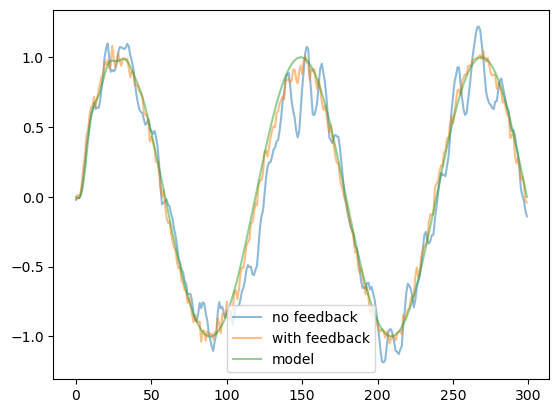

In [13]:
# check feedback
plt.plot(time_points, outputs_nofb, alpha=0.5, label='no feedback')
plt.plot(time_points, outputs_fb, alpha=0.5, label='with feedback')
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.legend()
plt.show()

## Kalman Filter

In [14]:
Obsv = control.obsv(A, C)
np.linalg.matrix_rank(Obsv)

2

In [15]:
L, _, _ = control.lqe(A, G, C, Qn, Rn)
L

array([[ 0.46781911, -0.00210063, -0.01002243, ..., -0.01658958,
        -0.02138524,  0.01207229],
       [-0.00210063,  0.48830184,  0.043705  , ...,  0.03698748,
         0.04290234,  0.02552175],
       [-0.01002243,  0.043705  ,  0.47990124, ...,  0.09665075,
         0.06584257,  0.06579893],
       ...,
       [-0.01658958,  0.03698748,  0.09665075, ...,  0.62460915,
         0.04921998,  0.03508532],
       [-0.02138524,  0.04290234,  0.06584257, ...,  0.04921998,
         0.4316283 ,  0.07106562],
       [ 0.01207229,  0.02552175,  0.06579893, ...,  0.03508532,
         0.07106562,  0.44047833]])

In [16]:
# manual simulation without feedback
kx_init = np.zeros((num_nodes, 1))
u = np.zeros((num_nodes, 1))
kxs = [kx_init]

activations_nofb = [init_activations]
outputs_nofb = []
ys_nofb = []

for t in time_points:
    # dynamic system
    last_acitvation = activations_nofb[-1]
    this_input = inputs[t] * input_weights.T
    this_noise = x_noises[:,t]
    this_ynoise = y_noises[:,t]

    this_activation = (1 - c) * last_acitvation + c * weight_matrix @ last_acitvation + c * B @ this_input + c * G @ this_noise
    this_output = output_weight_matrix @ this_activation
    this_y = C @ this_activation + this_ynoise

    activations_nofb.append(this_activation)
    outputs_nofb.append(this_output.item())
    ys_nofb.append(this_y)

    # kalman system
    last_kx = kxs[-1]
    theo_this_kx = (1 - c) * last_kx + c * weight_matrix @ last_kx + c * B @ this_input
    # theo_this_y = C @ theo_this_kx
    theo_this_y = C @ last_kx
    this_kx = theo_this_kx + c * L @ (this_y - theo_this_y)
    # this_kx = (1 - c) * last_kx + c * weight_matrix @ last_kx + c * B @ this_input + L @ this_y - L @ (C @ last_kx)
    kxs.append(this_kx)

In [17]:
diffs = [np.sum(np.power(x[0] - x[1],2))/num_nodes for x in zip(activations_nofb, kxs)]
print(np.mean(diffs))

0.017635210015158675


In [18]:
koutputs = [(output_weight_matrix @ x).item() for x in kxs]
# koutputs

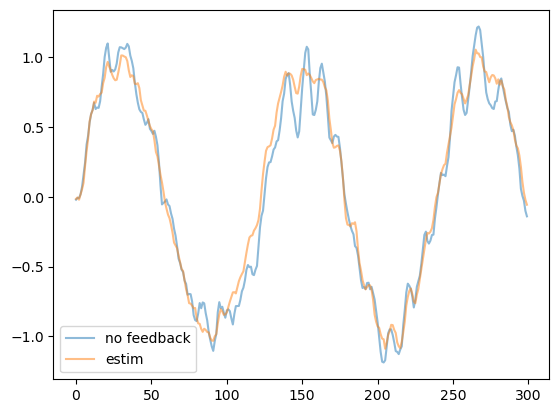

In [19]:
# check feedback
plt.plot(time_points, outputs_nofb, alpha=0.5, label='no feedback')
plt.plot(time_points, koutputs[1:], alpha=0.5, label='estim')
# plt.plot(time_points, outputs_fb, alpha=0.5, label='with feedback')
# plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.legend()
plt.show()

### Combine LQG

In [20]:
# lqr
K, _, _ = control.lqr(A,B,Q,R)
print(K.shape)
K

(32, 32)


array([[ 9.06699323,  0.01731659, -0.02648689, ..., -0.0577338 ,
        -0.23468874, -0.19358503],
       [ 0.01731659,  9.08137553,  0.07095863, ..., -0.04261189,
        -0.11524824, -0.19109874],
       [-0.02648689,  0.07095863,  9.04882814, ..., -0.03919866,
         0.10700854,  0.24005932],
       ...,
       [-0.0577338 , -0.04261189, -0.03919866, ...,  8.98261368,
         0.09327994,  0.27069284],
       [-0.23468874, -0.11524824,  0.10700854, ...,  0.09327994,
         9.07826802,  0.31927984],
       [-0.19358503, -0.19109874,  0.24005932, ...,  0.27069284,
         0.31927984,  9.1888085 ]])

In [21]:
# Kalman filter
L, _, _ = control.lqe(A, G, C, Qn, Rn)
print(L.shape)
L

(32, 32)


array([[ 0.46781911, -0.00210063, -0.01002243, ..., -0.01658958,
        -0.02138524,  0.01207229],
       [-0.00210063,  0.48830184,  0.043705  , ...,  0.03698748,
         0.04290234,  0.02552175],
       [-0.01002243,  0.043705  ,  0.47990124, ...,  0.09665075,
         0.06584257,  0.06579893],
       ...,
       [-0.01658958,  0.03698748,  0.09665075, ...,  0.62460915,
         0.04921998,  0.03508532],
       [-0.02138524,  0.04290234,  0.06584257, ...,  0.04921998,
         0.4316283 ,  0.07106562],
       [ 0.01207229,  0.02552175,  0.06579893, ...,  0.03508532,
         0.07106562,  0.44047833]])

In [22]:
# manual simulation with kalman and lqr
activations_lqg = [init_activations]
activations_hat = [init_activations]
ideal_activations = activations.detach().numpy()
outputs_lqg = []

for t in np.arange(nt):

    # lqr
    last_acitvation_hat = activations_hat[-1]
    # last_acitvation_hat = activations_lqg[-1] # test without kalman
    this_ideal_activation = ideal_activations[t,:].reshape(-1,1)
    this_u = -K @ (last_acitvation_hat - this_ideal_activation)
    # this_u = np.ones((num_nodes,1)) # test without lqr

    # dynamic system
    last_acitvation = activations_lqg[-1]
    this_input = inputs[t] * input_weights.T
    this_xnoise = x_noises[:,t].reshape(-1,1)
    this_ynoise = y_noises[:,t].reshape(-1,1)
    
    this_activation = (1 - c) * last_acitvation + c * weight_matrix @ last_acitvation + c * B @ this_input + c * B @ this_u + c * G @ this_xnoise
    this_output = output_weight_matrix @ this_activation
    this_y = C @ this_activation + this_ynoise
    
    activations_lqg.append(this_activation)
    outputs_lqg.append(this_output.item())

    # Kalman system
    theo_this_kx = (1 - c) * last_acitvation_hat + c * weight_matrix @ last_acitvation_hat + c * B @ this_input + c * B @ this_u
    # theo_this_kx = (1 - c) * last_acitvation_hat + c * weight_matrix @ last_acitvation_hat + c * B @ this_input
    theo_this_y = C @ theo_this_kx
    # theo_this_y = C @ last_acitvation_hat
    this_acitvation_hat = theo_this_kx + c * L @ (this_y - theo_this_y)
    activations_hat.append(this_acitvation_hat)

    # print(np.mean(np.abs(this_acitvation_hat - this_activation)))

In [23]:
diffs = [np.sum(np.power(x[0] - x[1],2))/num_nodes for x in zip(activations_lqg, activations_hat)]
print(np.mean(diffs))

0.0169801963936824


In [24]:
tt = []
df = []
for i in range(len(ideal_activations)):
    p = activations_hat[i+1] - ideal_activations[i,:].reshape(-1,1)
    tmp = output_weight_matrix @ p
    tmp = tmp.item()

    tt.append(tmp)
    df.append(np.mean(np.power(p,2)))
print(np.mean(df))

0.002484751538632431


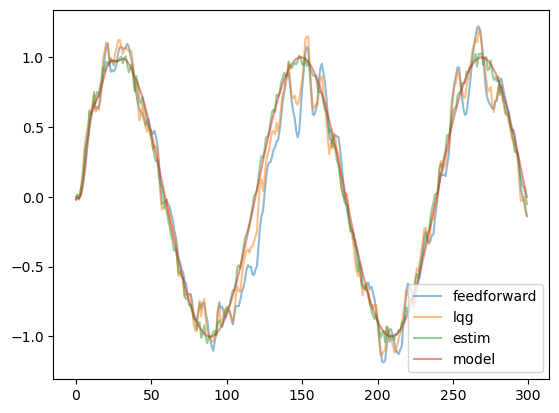

In [25]:
# check feedback
plt.plot(time_points, outputs_nofb, alpha=0.5, label='feedforward')
plt.plot(time_points, outputs_lqg, alpha=0.5, label='lqg')
kkoutputs = [(output_weight_matrix @ x).item() for x in activations_hat]
plt.plot(time_points, kkoutputs[1:], alpha=0.5, label='estim')
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.legend()
plt.show()